# Análisis Predictivo de COVID-19 para Estudiantes en Contexto de Exámenes

Este análisis emplea las técnicas de minería de datos y aprendizaje automático dadas en clase para 
identificar el riesgo de complicaciones de COVID-19 en estudiantes. Los datos 
provienen de los conjuntos de datos hospitalarios proporcionados que incluyen información 
sobre síntomas, comorbilidades y resultados de pruebas PCR.


### Objetivos de Negocio y Minería de Datos

**Objetivo de Negocio**: Crear un entorno de examen seguro al identificar a los estudiantes en riesgo de complicaciones graves por COVID-19. Esto permitirá a las instituciones académicas y sanitarias tomar decisiones preventivas.

**KPI de Negocio**: Tasa de identificación de estudiantes de alto riesgo.

**Objetivo de Minería de Datos**: Desarrollar un modelo de clasificación para segmentar a los estudiantes en niveles de riesgo (alto, bajo y enfermo) por lo que dado el conjunto de datos los segmentaremos en un rango de edad por lo que el enfoque estará en estudiantes de 15 a 18 años, quienes corresponden al grupo en etapa final de secundaria enfrentando exámenes críticos, según lo indicado en plan del proyecto (
1st assigment: Project Plan).

**KPI de Minería de Datos**: Precisión y sensibilidad en la predicción de estudiantes de alto riesgo para aplicar medidas preventivas.


In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn openpyxl

#### Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
)
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

#### Cargar los Datos

In [4]:
file_path_hospital1 = './hospital1.xlsx'
file_path_hospital2 = './hospital2.xlsx'

hospital1_data = pd.read_excel(file_path_hospital1)
hospital2_data = pd.read_excel(file_path_hospital2)

# Mostrar las primeras filas de cada dataset
hospital1_data.head(), hospital2_data.head()



(   patient ID  patient ID.1 nationality  age gender K=female E=male  \
 0    11850006      11850006        T.C.   47                      K   
 1     4373630       4373630        T.C.   23                      K   
 2    12172023      12172023        T.C.   26                      K   
 3    72856168      72856168        T.C.   60                      K   
 4    72200559      72200559        T.C.   72                      K   
 
   date_of_first_symptoms BASVURUTARIHI  fever_temperature  oxygen_saturation  \
 0             2022-01-01    2022-01-01               38.2               96.0   
 1             2022-01-01    2022-01-01               37.0               96.0   
 2             2022-01-01    2022-01-01               38.0               95.0   
 3             2022-01-01    2022-01-01               36.5               95.0   
 4             2021-12-22    2021-12-22               36.9               96.0   
 
    history_of_fever  ...  chronic_hematologic_disease  AIDS_HIV  \
 0        

#### Preprocesamiento de Datos

In [5]:
# Filtro por rango de edad (15 a 18 años)
hospital1_data = hospital1_data[hospital1_data['age'].between(15, 18)]
hospital2_data = hospital2_data[hospital2_data['age'].between(15, 18)]

# Estandarización de nombres de columnas para facilitar la combinación
hospital1_data.columns = hospital1_data.columns.str.lower().str.replace(" ", "_")
hospital2_data.columns = hospital2_data.columns.str.lower().str.replace(" ", "_")

# Eliminación de columnas duplicadas en hospital1_data
hospital1_data = hospital1_data.loc[:, ~hospital1_data.columns.duplicated()]

# Renombrar columnas para consistencia
hospital1_data.rename(columns={'gender_k=female_e=male': 'sex', 'basvurutarihi': 'admission_date'}, inplace=True)

# Reemplazo de valores incorrectos en hospital2_data
hospital2_data['oxygen_saturation'] = hospital2_data['oxygen_saturation'].apply(lambda x: pd.NA if x == -1 else x)

# Combinación de los datasets
combined_data = pd.concat([hospital1_data, hospital2_data], ignore_index=True)


# Validación de valores únicos en columnas categóricas
print("Valores únicos en 'sex':", combined_data['sex'].unique())
print("Valores únicos en 'pcr_result':", combined_data['pcr_result'].unique())

Valores únicos en 'sex': ['E' 'K']
Valores únicos en 'pcr_result': ['positive' 'negative' nan]


#### Validación de Valores Atípicos


In [6]:
def detect_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return df[(df[col] < lower_bound) | (df[col] > upper_bound)]

# Detección de valores atípicos en temperatura y saturación de oxígeno
outliers_temp = detect_outliers(combined_data, 'fever_temperature')
outliers_oxygen = detect_outliers(combined_data, 'oxygen_saturation')

print(f"Outliers en temperatura corporal: {len(outliers_temp)}")
print(f"Outliers en saturación de oxígeno: {len(outliers_oxygen)}")


Outliers en temperatura corporal: 0
Outliers en saturación de oxígeno: 85


#### Imputación de Valores Nulos

In [7]:
# Imputación de valores nulos con KNNImputer
num_cols = combined_data.select_dtypes(include=['float64', 'int64']).columns
knn_imputer = KNNImputer(n_neighbors=5)
combined_data[num_cols] = knn_imputer.fit_transform(combined_data[num_cols])
print("Columnas numéricas seleccionadas para imputación:", num_cols)

# Imputación de valores nulos en columnas numéricas
knn_imputer = KNNImputer(n_neighbors=5)
num_data = pd.DataFrame(knn_imputer.fit_transform(combined_data[num_cols]), columns=num_cols)

# Reintegrar las columnas numéricas imputadas en el dataset
combined_data[num_cols] = num_data

# Manejo de valores categóricos faltantes
cat_cols = ['sex', 'pcr_result']
for col in cat_cols:
    if col in combined_data.columns:
        combined_data[col].fillna(combined_data[col].mode()[0], inplace=True)

# Codificación de variables categóricas
cat_cols = combined_data.select_dtypes(include=['object']).columns
combined_data = pd.get_dummies(combined_data, columns=['sex', 'pcr_result'], drop_first=True)

# Verificación final de nulos
print(combined_data.isnull().sum())

Columnas numéricas seleccionadas para imputación: Index(['patient_id', 'patient_id.1', 'age', 'fever_temperature',
       'oxygen_saturation', 'history_of_fever', 'cough', 'sore_throat',
       'runny_nose', 'wheezing', 'shortness_of_breath',
       'lower_chest_wall_indrawing', 'chest_pain', 'conjunctivitis',
       'lymphadenopathy', 'headache', 'loss_of_smell', 'loss_of_taste',
       'fatigue_malaise', 'anorexia', 'altered_consciousness_confusion',
       'muscle_aches', 'joint_pain', 'inability_to_walk', 'abdominal_pain',
       'diarrhoea', 'vomiting_nausea', 'skin_rash', 'bleeding',
       'other_symptoms', 'chronic_cardiac_disease', 'hypertension',
       'chronic_pulmonary_disease', 'asthma', 'chronic_kidney_disease',
       'obesity', 'liver_disease', 'asplenia', 'chronic_neurological_disorder',
       'malignant_neoplasm', 'chronic_hematologic_disease', 'aids_hiv',
       'diabetes_mellitus_type_1', 'diabetes_mellitus_type_2',
       'rheumatologic_disorder', 'dementia', 'tu

C:\Users\Usema\AppData\Local\Temp\ipykernel_1460\780932282.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data[col].fillna(combined_data[col].mode()[0], inplace=True)


##### Eliminar columna duplicadas, irrelevantes o completamente nulas


In [8]:
# Eliminar columna duplicadas, irrelevantes o completamente nulas
columns_to_drop = ['patient_id.1', 'nationality', 'country_of_residence']
combined_data.drop(columns=[col for col in columns_to_drop if col in combined_data.columns], inplace=True)


#### Estructura del Dataset Final

In [9]:
# Comprobar la estructura del dataset final
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 53 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   patient_id                       398 non-null    float64       
 1   age                              398 non-null    float64       
 2   date_of_first_symptoms           398 non-null    datetime64[ns]
 3   admission_date                   398 non-null    datetime64[ns]
 4   fever_temperature                398 non-null    float64       
 5   oxygen_saturation                398 non-null    float64       
 6   history_of_fever                 398 non-null    float64       
 7   cough                            398 non-null    float64       
 8   sore_throat                      398 non-null    float64       
 9   runny_nose                       398 non-null    float64       
 10  wheezing                         398 non-null    float64      

#### Análisis Exploratorio de Datos (EDA)

Estadísticas descriptivas del dataset:
         patient_id         age         date_of_first_symptoms  \
count  3.980000e+02  398.000000                            398   
mean   5.005053e+07   16.693467  2021-11-04 13:44:10.251256064   
min    1.574490e+05   15.000000            2021-03-13 08:35:00   
25%    2.546132e+07   16.000000            2021-09-08 06:00:00   
50%    5.171247e+07   17.000000            2021-12-02 18:44:30   
75%    7.477118e+07   18.000000            2022-01-08 00:00:00   
max    9.974064e+07   18.000000            2022-03-14 00:00:00   
std    2.974068e+07    1.109386                            NaN   

                      admission_date  fever_temperature  oxygen_saturation  \
count                            398         398.000000         398.000000   
mean   2021-11-04 13:44:10.251256064          37.393920          93.326633   
min              2021-03-13 08:35:00          35.600000          -1.000000   
25%              2021-09-08 06:00:00          36.70000

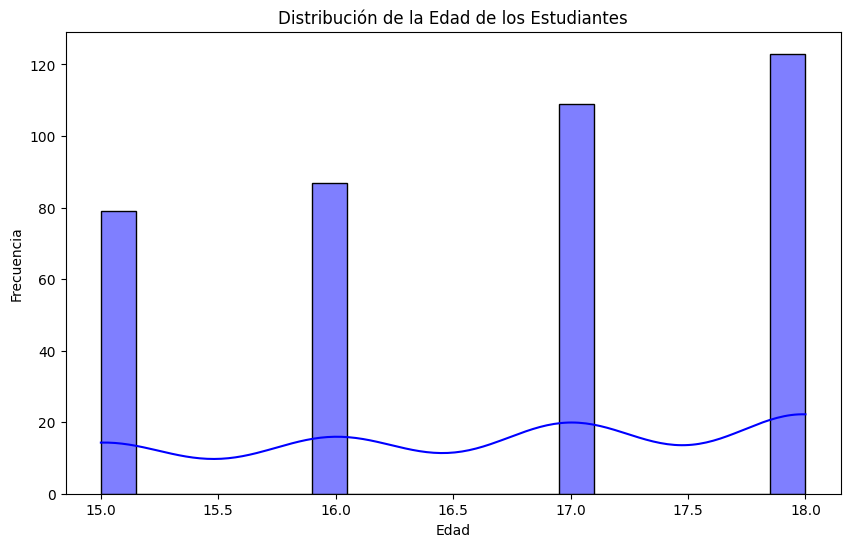

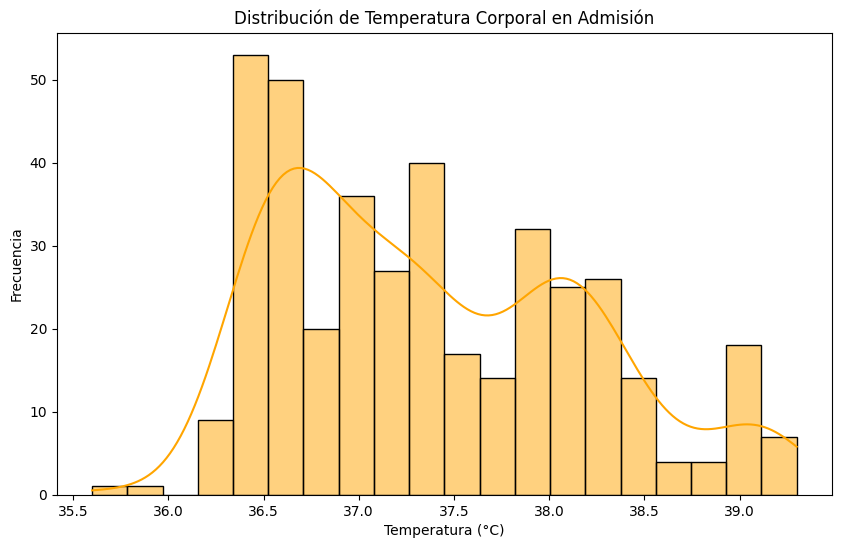

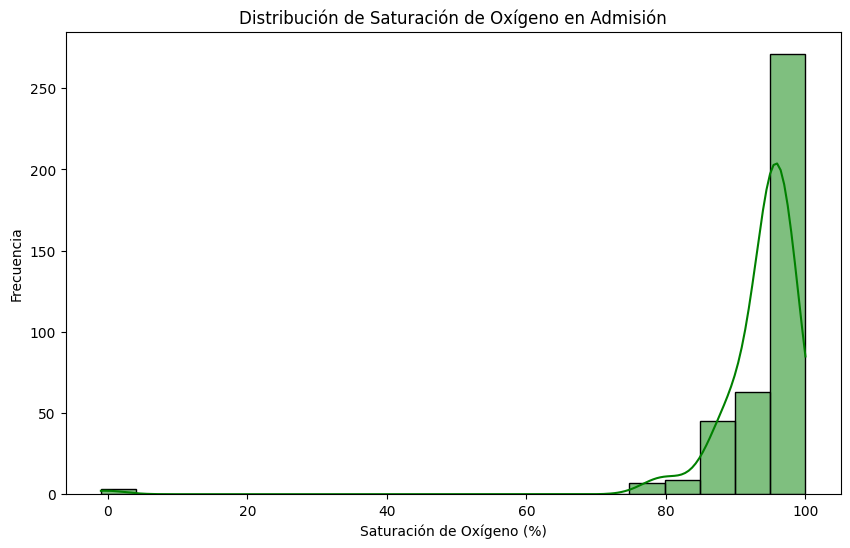

C:\Users\Usema\AppData\Local\Temp\ipykernel_1460\2235986543.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=combined_data, palette='muted')


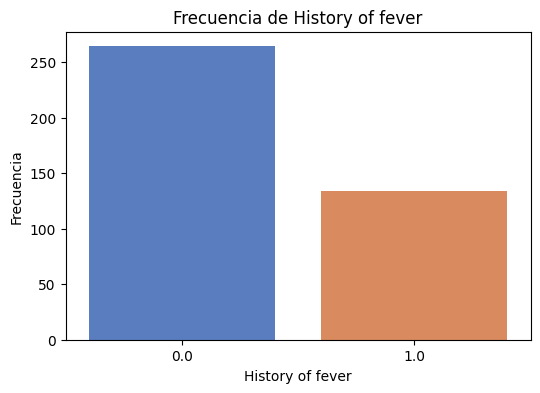

C:\Users\Usema\AppData\Local\Temp\ipykernel_1460\2235986543.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=combined_data, palette='muted')


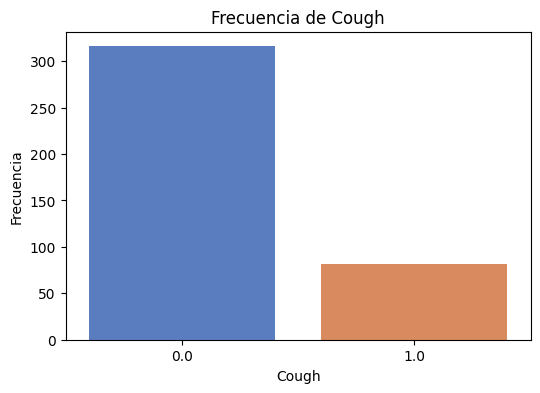

C:\Users\Usema\AppData\Local\Temp\ipykernel_1460\2235986543.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=combined_data, palette='muted')


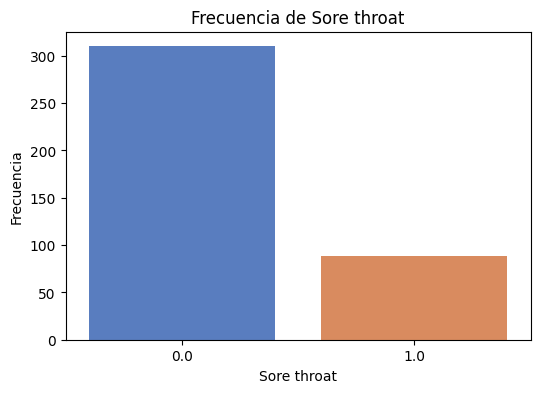

C:\Users\Usema\AppData\Local\Temp\ipykernel_1460\2235986543.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=combined_data, palette='muted')


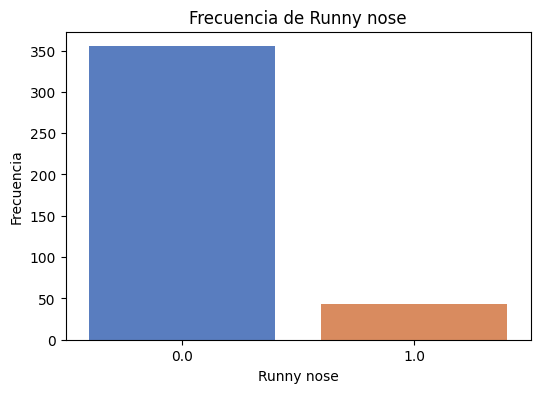

C:\Users\Usema\AppData\Local\Temp\ipykernel_1460\2235986543.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=combined_data, palette='muted')


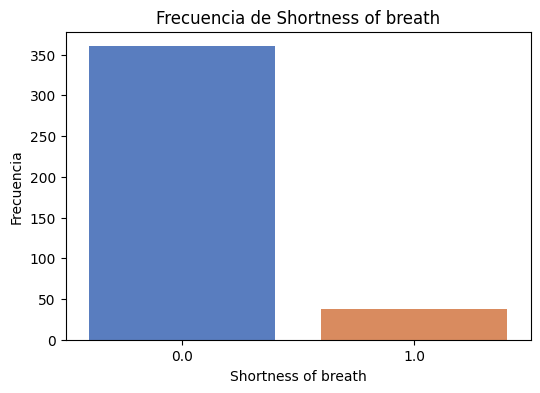

C:\Users\Usema\AppData\Local\Temp\ipykernel_1460\2235986543.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=combined_data, palette='muted')


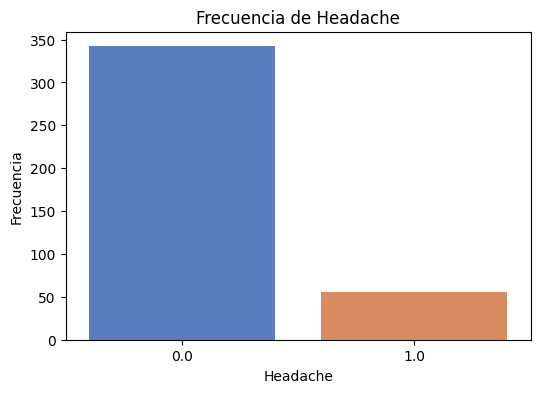

C:\Users\Usema\AppData\Local\Temp\ipykernel_1460\2235986543.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=combined_data, palette='muted')


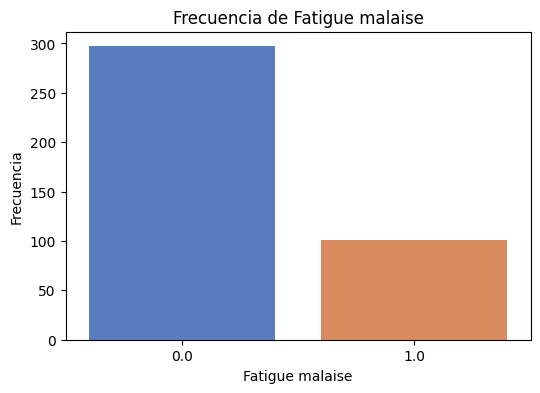

C:\Users\Usema\AppData\Local\Temp\ipykernel_1460\2235986543.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=combined_data, palette='muted')


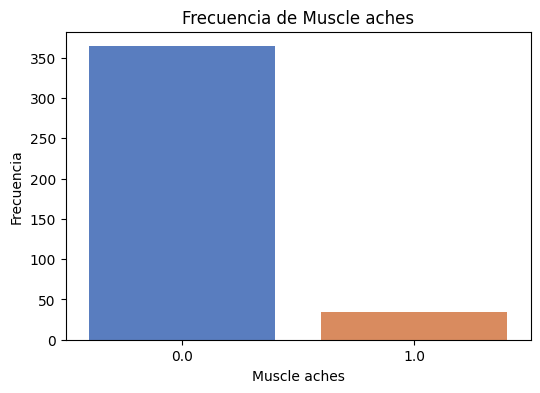

C:\Users\Usema\AppData\Local\Temp\ipykernel_1460\2235986543.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=combined_data, palette='muted')


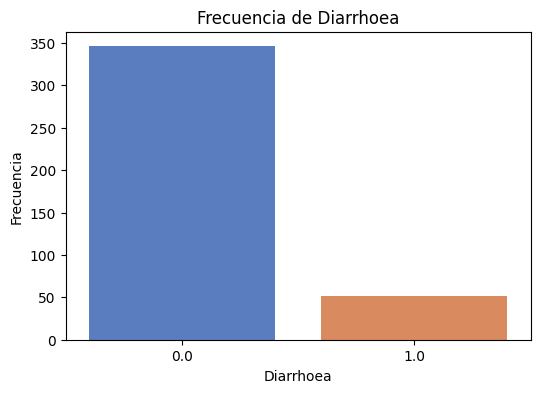

C:\Users\Usema\AppData\Local\Temp\ipykernel_1460\2235986543.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=combined_data, palette='muted')


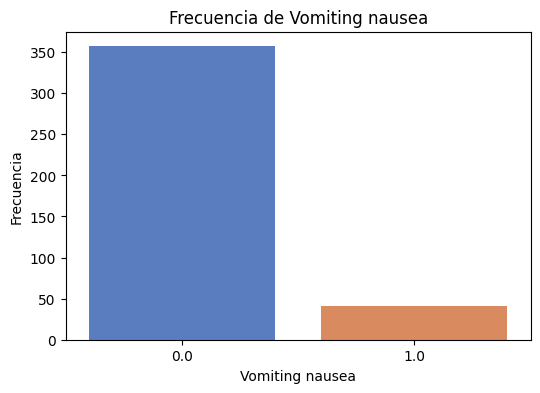

C:\Users\Usema\AppData\Local\Temp\ipykernel_1460\2235986543.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=combined_data, palette='muted')


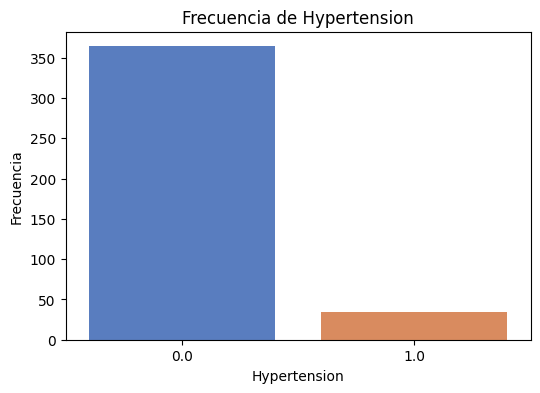

C:\Users\Usema\AppData\Local\Temp\ipykernel_1460\2235986543.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=combined_data, palette='muted')


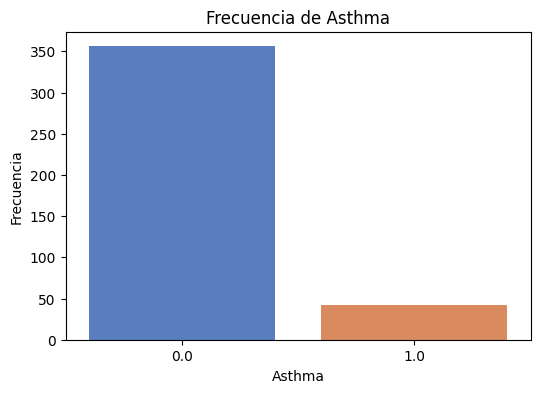

C:\Users\Usema\AppData\Local\Temp\ipykernel_1460\2235986543.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=combined_data, palette='muted')


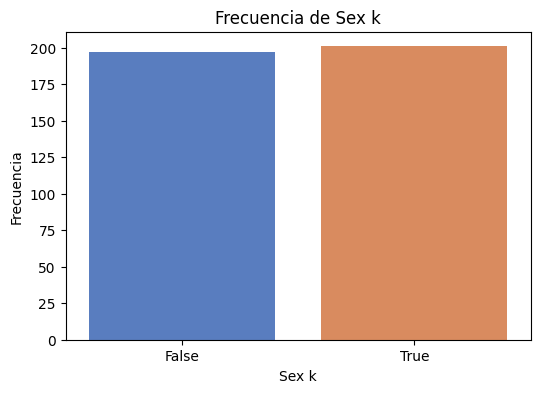

C:\Users\Usema\AppData\Local\Temp\ipykernel_1460\2235986543.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=combined_data, palette='muted')


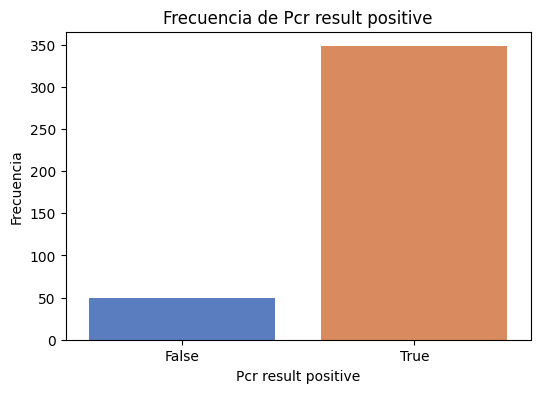

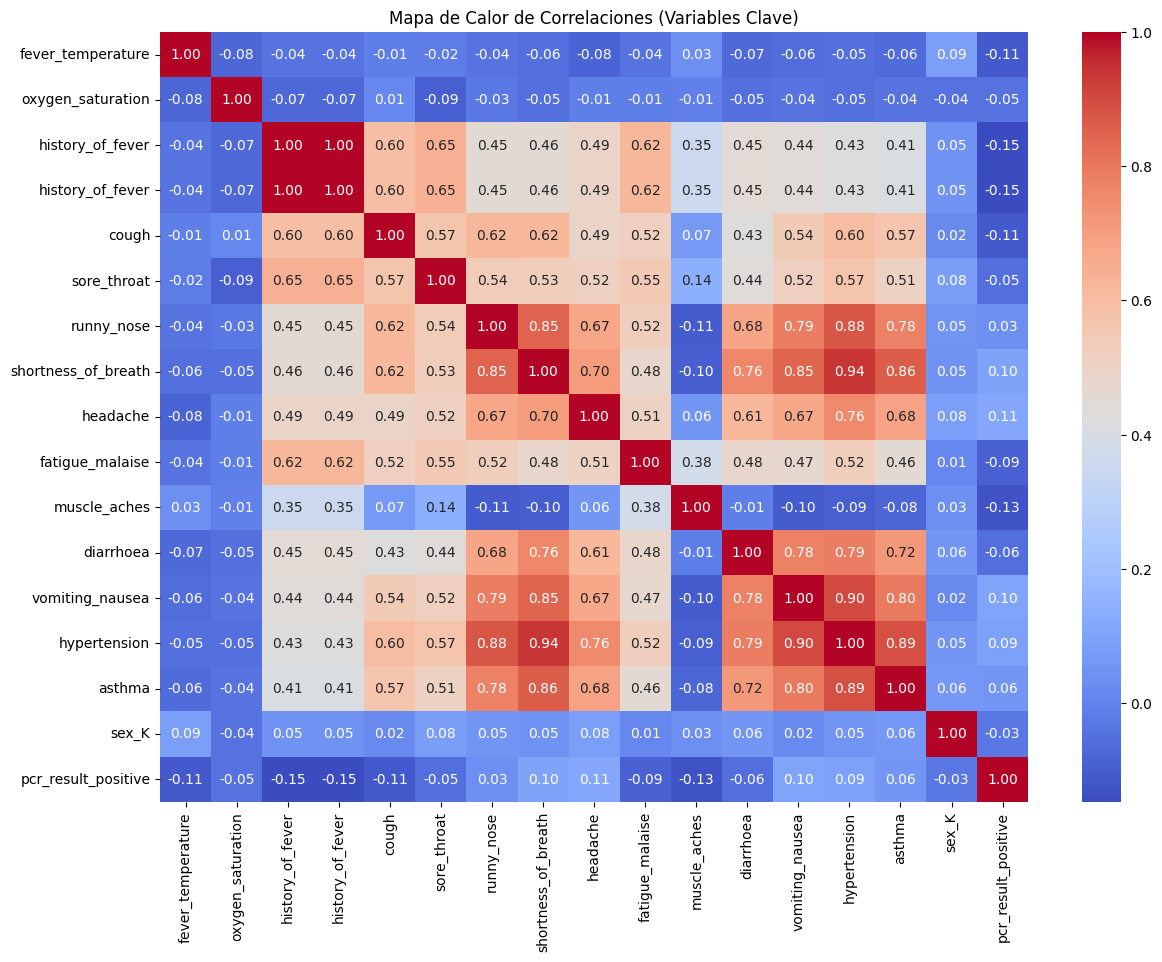

In [10]:
# Estadísticas descriptivas generales
print("Estadísticas descriptivas del dataset:")
print(combined_data.describe())

# Distribución de la Edad
plt.figure(figsize=(10, 6))
sns.histplot(combined_data['age'], bins=20, kde=True, color='blue')
plt.title('Distribución de la Edad de los Estudiantes')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()

# Distribución de la Temperatura Corporal
if 'fever_temperature' in combined_data.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(combined_data['fever_temperature'], bins=20, kde=True, color='orange')
    plt.title('Distribución de Temperatura Corporal en Admisión')
    plt.xlabel('Temperatura (°C)')
    plt.ylabel('Frecuencia')
    plt.show()

# Distribución de la Saturación de Oxígeno
if 'oxygen_saturation' in combined_data.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(combined_data['oxygen_saturation'], bins=20, kde=True, color='green')
    plt.title('Distribución de Saturación de Oxígeno en Admisión')
    plt.xlabel('Saturación de Oxígeno (%)')
    plt.ylabel('Frecuencia')
    plt.show()

# Relación entre PCR Result y otras variables
if 'pcr_result_1' in combined_data.columns:
    plt.figure(figsize=(6, 6))
    sns.countplot(x='pcr_result_1', data=combined_data, palette='viridis')
    plt.title('Distribución de Resultados de PCR')
    plt.xlabel('Resultado de PCR (1 = Positivo)')
    plt.ylabel('Frecuencia')
    plt.show()

# Análisis de comorbilidades (solo variables con más del 5% de incidencia)
binary_cols = [col for col in combined_data.columns if combined_data[col].dropna().isin([0, 1]).all()]
comorbidity_threshold = 0.05  # Filtrar variables con al menos 5% de incidencia
relevant_binary_cols = [
    col for col in binary_cols
    if combined_data[col].mean() > comorbidity_threshold
]
for col in relevant_binary_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, data=combined_data, palette='muted')
    plt.title(f'Frecuencia de {col.replace("_", " ").capitalize()}')
    plt.xlabel(col.replace("_", " ").capitalize())
    plt.ylabel('Frecuencia')
    plt.show()

# Heatmap de correlación (centrado en variables relevantes)
plt.figure(figsize=(14, 10))
# Seleccionar las columnas numéricas con más relevancia (e.g., síntomas y resultados)
correlation_columns = ['fever_temperature', 'oxygen_saturation', 'history_of_fever'] + relevant_binary_cols
correlation_matrix = combined_data[correlation_columns].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Mapa de Calor de Correlaciones (Variables Clave)')
plt.show()


#### Justificación del Preprocesamiento

- **Imputación de Valores Nulos**: Se utilizan la mediana y la moda para manejar valores faltantes. Esto ayuda a evitar sesgos y asegura una consistencia de datos.
- **Codificación de Variables Categóricas**: One-hot encoding se aplica a `sex` y `PCR_result` para convertir categorías en un formato adecuado para el modelo.
- **Eliminación de Valores Inconsistentes**: Los valores anómalos en `oxygen_saturation` se manejan para mantener la precisión del modelo.


#### Selección del Modelo y Justificación

Se selecciona `Random Forest`:

Dado que el objetivo del ejercicio es predecir el riesgo de complicaciones relacionadas con COVID-19 en estudiantes, utilizaremos un modelo de clasificación Random Forest por las siguientes razones:

    - Capacidades de manejo de datos heterogéneos: Puede manejar variables numéricas y categóricas eficientemente.
    - Robustez frente al sobreajuste: Su capacidad para realizar ensambles de árboles ayuda a controlar el sobreajuste.
    - Interpretabilidad: Proporciona métricas de importancia de las variables que ayudan a entender qué factores son más determinantes en el riesgo.

#### Preparación de los Datos

In [11]:
# Eliminar columnas no numéricas
columns_to_remove = combined_data.select_dtypes(include=['datetime64']).columns
print(f"Eliminando columnas no numéricas: {list(columns_to_remove)}")
X = combined_data.drop(columns=columns_to_remove, errors='ignore')

# Seleccionar columnas relacionadas con PCR (variable objetivo)
pcr_columns = [col for col in combined_data.columns if 'pcr_result' in col]
y = combined_data[pcr_columns[0]]  # Variable objetivo binaria
X = combined_data.drop(columns=pcr_columns)

# Verificar y seleccionar columnas numéricas
X = X.select_dtypes(include=['float64', 'int64', 'uint8'])
print(f"Columnas seleccionadas para X: {X.columns}")

# Manejo de valores nulos (si aplica)
X = X.fillna(X.median())

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Eliminando columnas no numéricas: ['date_of_first_symptoms', 'admission_date']
Columnas seleccionadas para X: Index(['patient_id', 'age', 'fever_temperature', 'oxygen_saturation',
       'history_of_fever', 'cough', 'sore_throat', 'runny_nose', 'wheezing',
       'shortness_of_breath', 'lower_chest_wall_indrawing', 'chest_pain',
       'conjunctivitis', 'lymphadenopathy', 'headache', 'loss_of_smell',
       'loss_of_taste', 'fatigue_malaise', 'anorexia',
       'altered_consciousness_confusion', 'muscle_aches', 'joint_pain',
       'inability_to_walk', 'abdominal_pain', 'diarrhoea', 'vomiting_nausea',
       'skin_rash', 'bleeding', 'other_symptoms', 'chronic_cardiac_disease',
       'hypertension', 'chronic_pulmonary_disease', 'asthma',
       'chronic_kidney_disease', 'obesity', 'liver_disease', 'asplenia',
       'chronic_neurological_disorder', 'malignant_neoplasm',
       'chronic_hematologic_disease', 'aids_hiv', 'diabetes_mellitus_type_1',
       'diabetes_mellitus_type_2', 'rhe

#### Entrenamiento Inicial del Modelo

In [12]:
# Entrenar un modelo base de Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predicciones iniciales
y_pred = rf.predict(X_test)
y_pred_prob = rf.predict_proba(X_test)[:, 1]

# Evaluación del modelo base
print("Desempeño del Modelo Random Forest Base:")
print("Precisión (Accuracy):", accuracy_score(y_test, y_pred))
print("Precisión (Precision):", precision_score(y_test, y_pred))
print("Sensibilidad (Recall):", recall_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))

Desempeño del Modelo Random Forest Base:
Precisión (Accuracy): 0.8625
Precisión (Precision): 0.8589743589743589
Sensibilidad (Recall): 1.0
F1-Score: 0.9241379310344827


 #### Optimización de Hiperparámetros con GridSearchCV

In [13]:
# Definir los parámetros a optimizar
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Búsqueda con GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid,
                           scoring='f1', cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Mejor modelo obtenido
best_rf = grid_search.best_estimator_

Fitting 5 folds for each of 162 candidates, totalling 810 fits


#### Evaluación del Modelo Optimizado

In [14]:
# Predicciones y probabilidades
y_pred = best_rf.predict(X_test)
y_pred_prob = best_rf.predict_proba(X_test)[:, 1]

# Métricas de evaluación
print("Desempeño del Modelo Optimizado Random Forest:")
print("Precisión (Accuracy):", accuracy_score(y_test, y_pred))
print("Precisión (Precision):", precision_score(y_test, y_pred))
print("Sensibilidad (Recall):", recall_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))

# Matriz de confusión
print("\nMatriz de Confusión:\n", confusion_matrix(y_test, y_pred))
print("\nReporte de Clasificación:\n", classification_report(y_test, y_pred))

Desempeño del Modelo Optimizado Random Forest:
Precisión (Accuracy): 0.85
Precisión (Precision): 0.8481012658227848
Sensibilidad (Recall): 1.0
F1-Score: 0.9178082191780822

Matriz de Confusión:
 [[ 1 12]
 [ 0 67]]

Reporte de Clasificación:
               precision    recall  f1-score   support

       False       1.00      0.08      0.14        13
        True       0.85      1.00      0.92        67

    accuracy                           0.85        80
   macro avg       0.92      0.54      0.53        80
weighted avg       0.87      0.85      0.79        80



#### Visualización: Curvas ROC y Precision-Recall

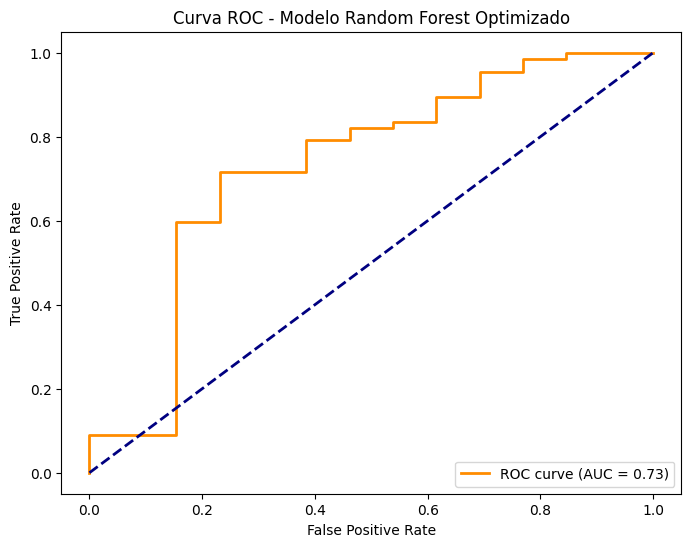

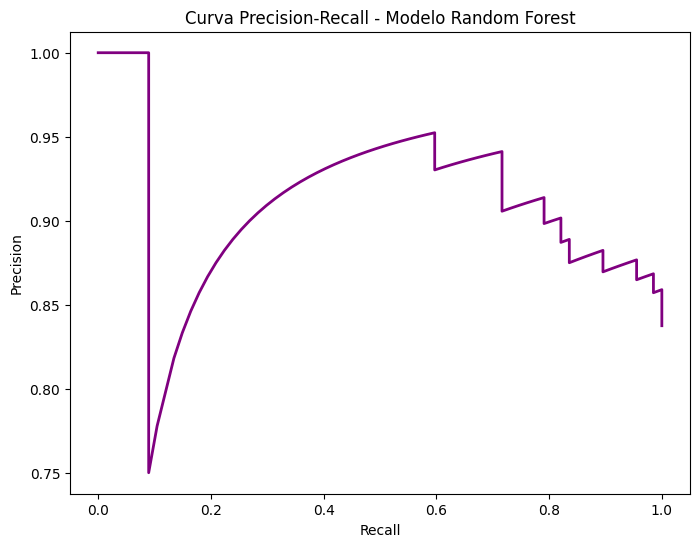

In [15]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Modelo Random Forest Optimizado')
plt.legend(loc='lower right')
plt.show()

# Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall - Modelo Random Forest')
plt.show()

**Evaluación de Métricas en Relación con KPIs**

- **Precisión**: Asegura que la mayoría de los estudiantes clasificados como de alto riesgo realmente lo sean, minimizando falsos positivos.
- **Recall (Sensibilidad)**: Evalúa la capacidad del modelo para identificar todos los estudiantes de alto riesgo, clave para medidas preventivas.
- **F1-Score**: Balancea precisión y recall, esencial en situaciones de salud pública donde ambos son importantes.
